# Bank Customer Churn -  XGBOOST 


# Importando Bibliotecas 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import logging
import joblib
import optuna
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy.special import expit
import matplotlib.cm as cm


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score, 
    roc_curve, confusion_matrix, classification_report, auc, make_scorer
)


from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek


from optuna.samplers import TPESampler


C:\Users\jgeov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dicinário de Dados 


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Points Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


# Análise Exploratória (EDA) & Data Wrangling 


In [2]:

# base_original = pd.read_csv('/kaggle/input/Customer-Churn-Records.csv', sep=',') #KAGGLE
base_original = pd.read_csv('C:/Users/jgeov/iCloudDrive/Treinamento/Treinamento Data Science/Projetos/Customer-Churn-Records.csv',sep=',') #LOCAL

#configs para nao quebrar linhas no print do  df
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_columns', None)

#primeiras linhas 
base_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Analisando primeiras impressões da base de dados


In [3]:
#Dimensões 
print("Numero de linhas:", base_original.shape[0]) 
print("Numero de colunas:", base_original.shape[1])


Numero de linhas: 10000
Numero de colunas: 18


In [4]:
#tipos
base_original.dtypes

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

In [5]:
#checando se há valores nulos 
base_original.isnull().sum()  
#valores nulos nao encontrados 

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [6]:
#removidas por serem meramente identificadoras: RowNumber, CustomerId e Surname 

df = base_original[['CreditScore',
                    'Gender',
                    'Geography',
                    'Age',
                    'Tenure',
                    'Balance',
                   'NumOfProducts',
                    'HasCrCard',
                    'IsActiveMember',
                   'EstimatedSalary',
                    'Complain',
                    'Satisfaction Score',
                   'Card Type',
                    'Point Earned',
                    'Exited'
                   ]]

# Resumo estatístico 
quanti = df[['EstimatedSalary', 'Balance', 'CreditScore', 'Age', 'Tenure', 'Point Earned']]
resumo_estati_quant = quanti.describe().style.format(lambda x: f'{x:,.1f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) # Formatação com 1 casa decimal e separadores invertidos

resumo_estati_quant

,EstimatedSalary,Balance,CreditScore,Age,Tenure,Point Earned
count,"10.000,0","10.000,0","10.000,0","10.000,0","10.000,0","10.000,0"
mean,"100.090,2","76.485,9","650,5","38,9","5,0","606,5"
std,"57.510,5","62.397,4","96,7","10,5","2,9","225,9"
min,"11,6","0,0","350,0","18,0","0,0","119,0"
25%,"51.002,1","0,0","584,0","32,0","3,0","410,0"
50%,"100.193,9","97.198,5","652,0","37,0","5,0","605,0"
75%,"149.388,2","127.644,2","718,0","44,0","7,0","801,0"
max,"199.992,5","250.898,1","850,0","92,0","10,0","1.000,0"


* Resumo estatistico de variaveis qualitativas (frequancias)

* Os resumos estatisticos sao importantes para primeiras nocoes de desbalance, a amplitude e distribuicao de valores
minimos maximos e um breve entendimento se serao necessarios tratamentos nessas variaveis, decorrentes dessas observacoes; 

* Podemos notar que a principio as ditribuicoes nao sao absurdas e o desbalance esta pricipalemnte nas variavies Complain e Exited (variavel alvo do estudo, a chamaremos de churn) indicando que sera necessario tratar isso;

* Franca tem mais observacoes que os demais paises; 

* A maioria dos clientes tem cartao de credito; 

* A maioria dos clientes tem entre 1 e 2 produtos. 


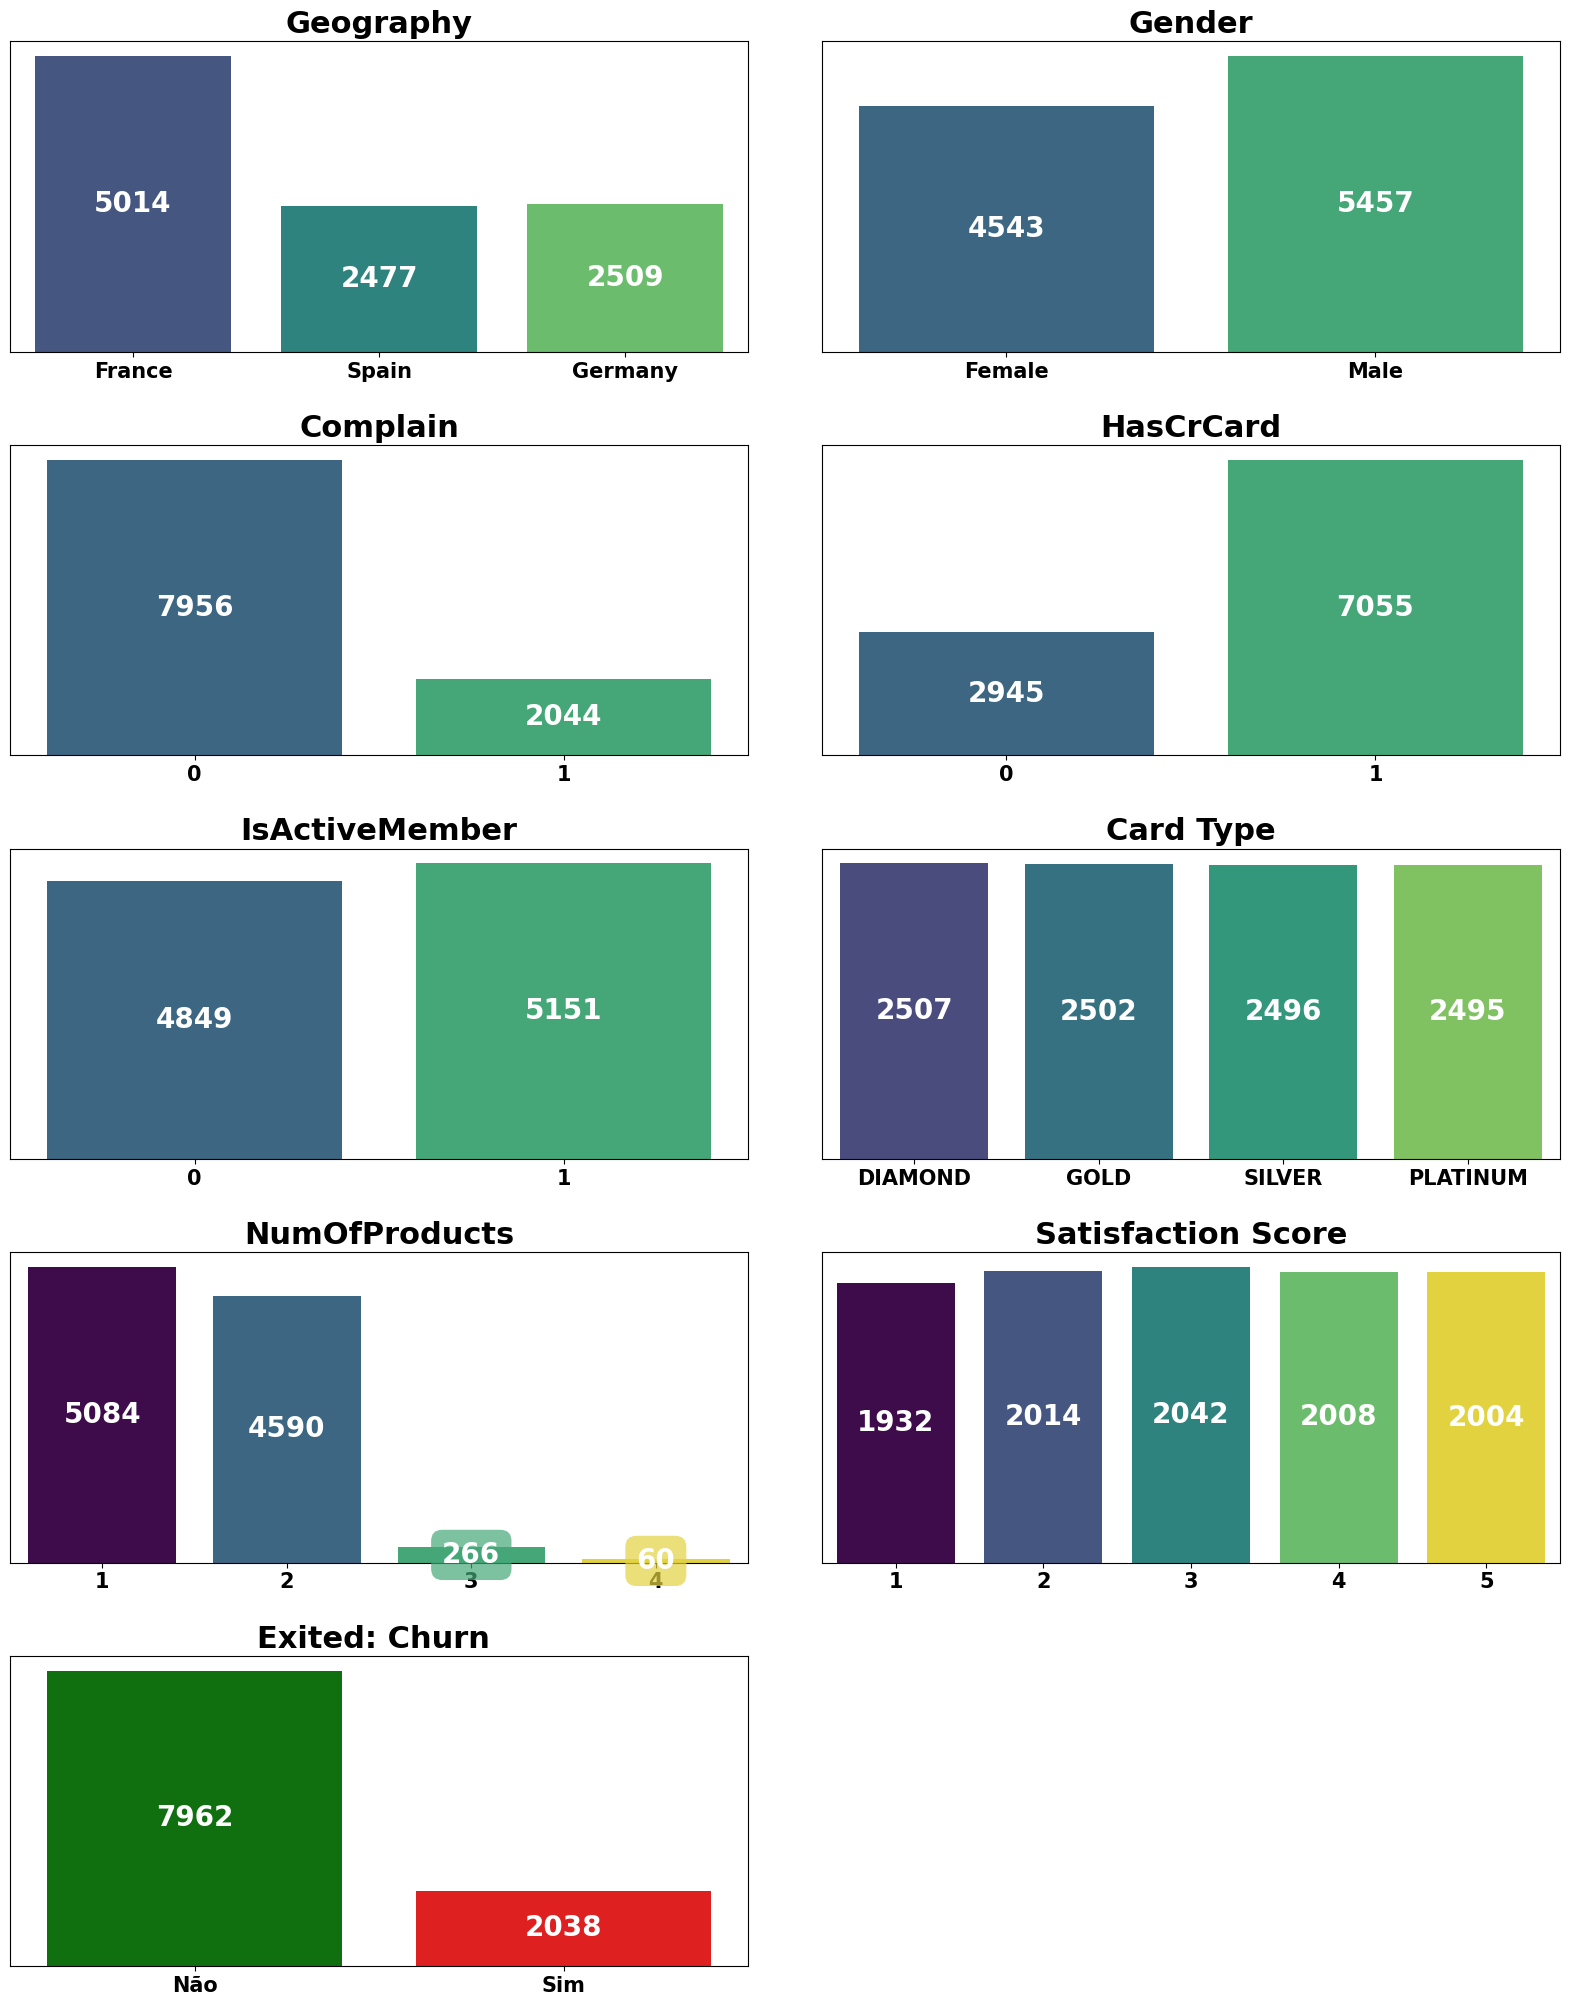

In [7]:
#Resumo estatistico 

#separando quali's para analise 
quali = df[['HasCrCard', 'IsActiveMember', 'Geography','Gender'
            ,'Complain','Exited','Card Type','NumOfProducts','Satisfaction Score']]

quali = quali.astype('object')

#quali.dtypes



def add_value_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        color = p.get_facecolor()
        ax.text(p.get_x() + p.get_width() / 2., height / 2.,
                f'{int(height)}',
                ha='center', va='center', fontsize=20, color='white', fontweight='bold',
                bbox=dict(facecolor=color, edgecolor='none', alpha=0.7,
                          boxstyle='round,pad=0.4', linewidth=1))

plt.figure(figsize=(20, 25))

# Geography
plt.subplot(5, 2, 1)
ax1 = plt.gca()
ax1.set_title('Geography', fontsize=22, fontweight='bold')
sns.countplot(x='Geography', hue='Geography', palette='viridis', data=base_original, ax=ax1, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax1)

# Gender
plt.subplot(5, 2, 2)
ax2 = plt.gca()
ax2.set_title('Gender', fontsize=22, fontweight='bold')
sns.countplot(x='Gender', hue='Gender', palette='viridis', data=base_original, ax=ax2, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax2)

# Complain
plt.subplot(5, 2, 3)
ax10 = plt.gca()
ax10.set_title('Complain', fontsize=22, fontweight='bold')
sns.countplot(x='Complain', hue='Complain', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# HasCrCard
plt.subplot(5, 2, 4)
ax5 = plt.gca()
ax5.set_title('HasCrCard', fontsize=22, fontweight='bold')
sns.countplot(x='HasCrCard', hue='HasCrCard', palette='viridis', data=base_original, ax=ax5, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax5)

# IsActiveMember
plt.subplot(5, 2, 5)
ax6 = plt.gca()
ax6.set_title('IsActiveMember', fontsize=22, fontweight='bold')
sns.countplot(x='IsActiveMember', hue='IsActiveMember', palette='viridis', data=base_original, ax=ax6, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax6)

# Card Type
plt.subplot(5, 2, 6)
ax10 = plt.gca()
ax10.set_title('Card Type', fontsize=22, fontweight='bold')
sns.countplot(x='Card Type', hue='Card Type', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# NumOfProducts
plt.subplot(5, 2, 7)
ax10 = plt.gca()
ax10.set_title('NumOfProducts', fontsize=22, fontweight='bold')
sns.countplot(x='NumOfProducts', hue='NumOfProducts', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# Satisfaction Score
plt.subplot(5, 2, 8)
ax11 = plt.gca()
ax11.set_title('Satisfaction Score', fontsize=22, fontweight='bold')
sns.countplot(x='Satisfaction Score', hue='Satisfaction Score', palette='viridis', data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)






# Exited
plt.subplot(5, 2, 9)
ax11 = plt.gca()
ax11.set_title('Exited: Churn ', fontsize=22, fontweight='bold')
custom_palette = ['green', 'red']
sns.countplot(x='Exited', hue='Exited', palette=custom_palette, data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)

ax11.set_xticks([0, 1])
ax11.set_xticklabels(['Não', 'Sim'], fontsize=15, fontweight='bold')

# Ajustando espaçamento
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.show()




* Visualizando o comportmento da variavel alvo (exited) em relacao as demais variaveis; 

* Vemos claramente que existe o disbalance de classes na variavel churn, pela cor verde presente fortemente em todas variaveis, posteriormente isso sera tratado/mitigado; 

* Ja e possivel notar um forte indicio de alta correlacao entre churn e complain, posteriormente isso sera testado. 



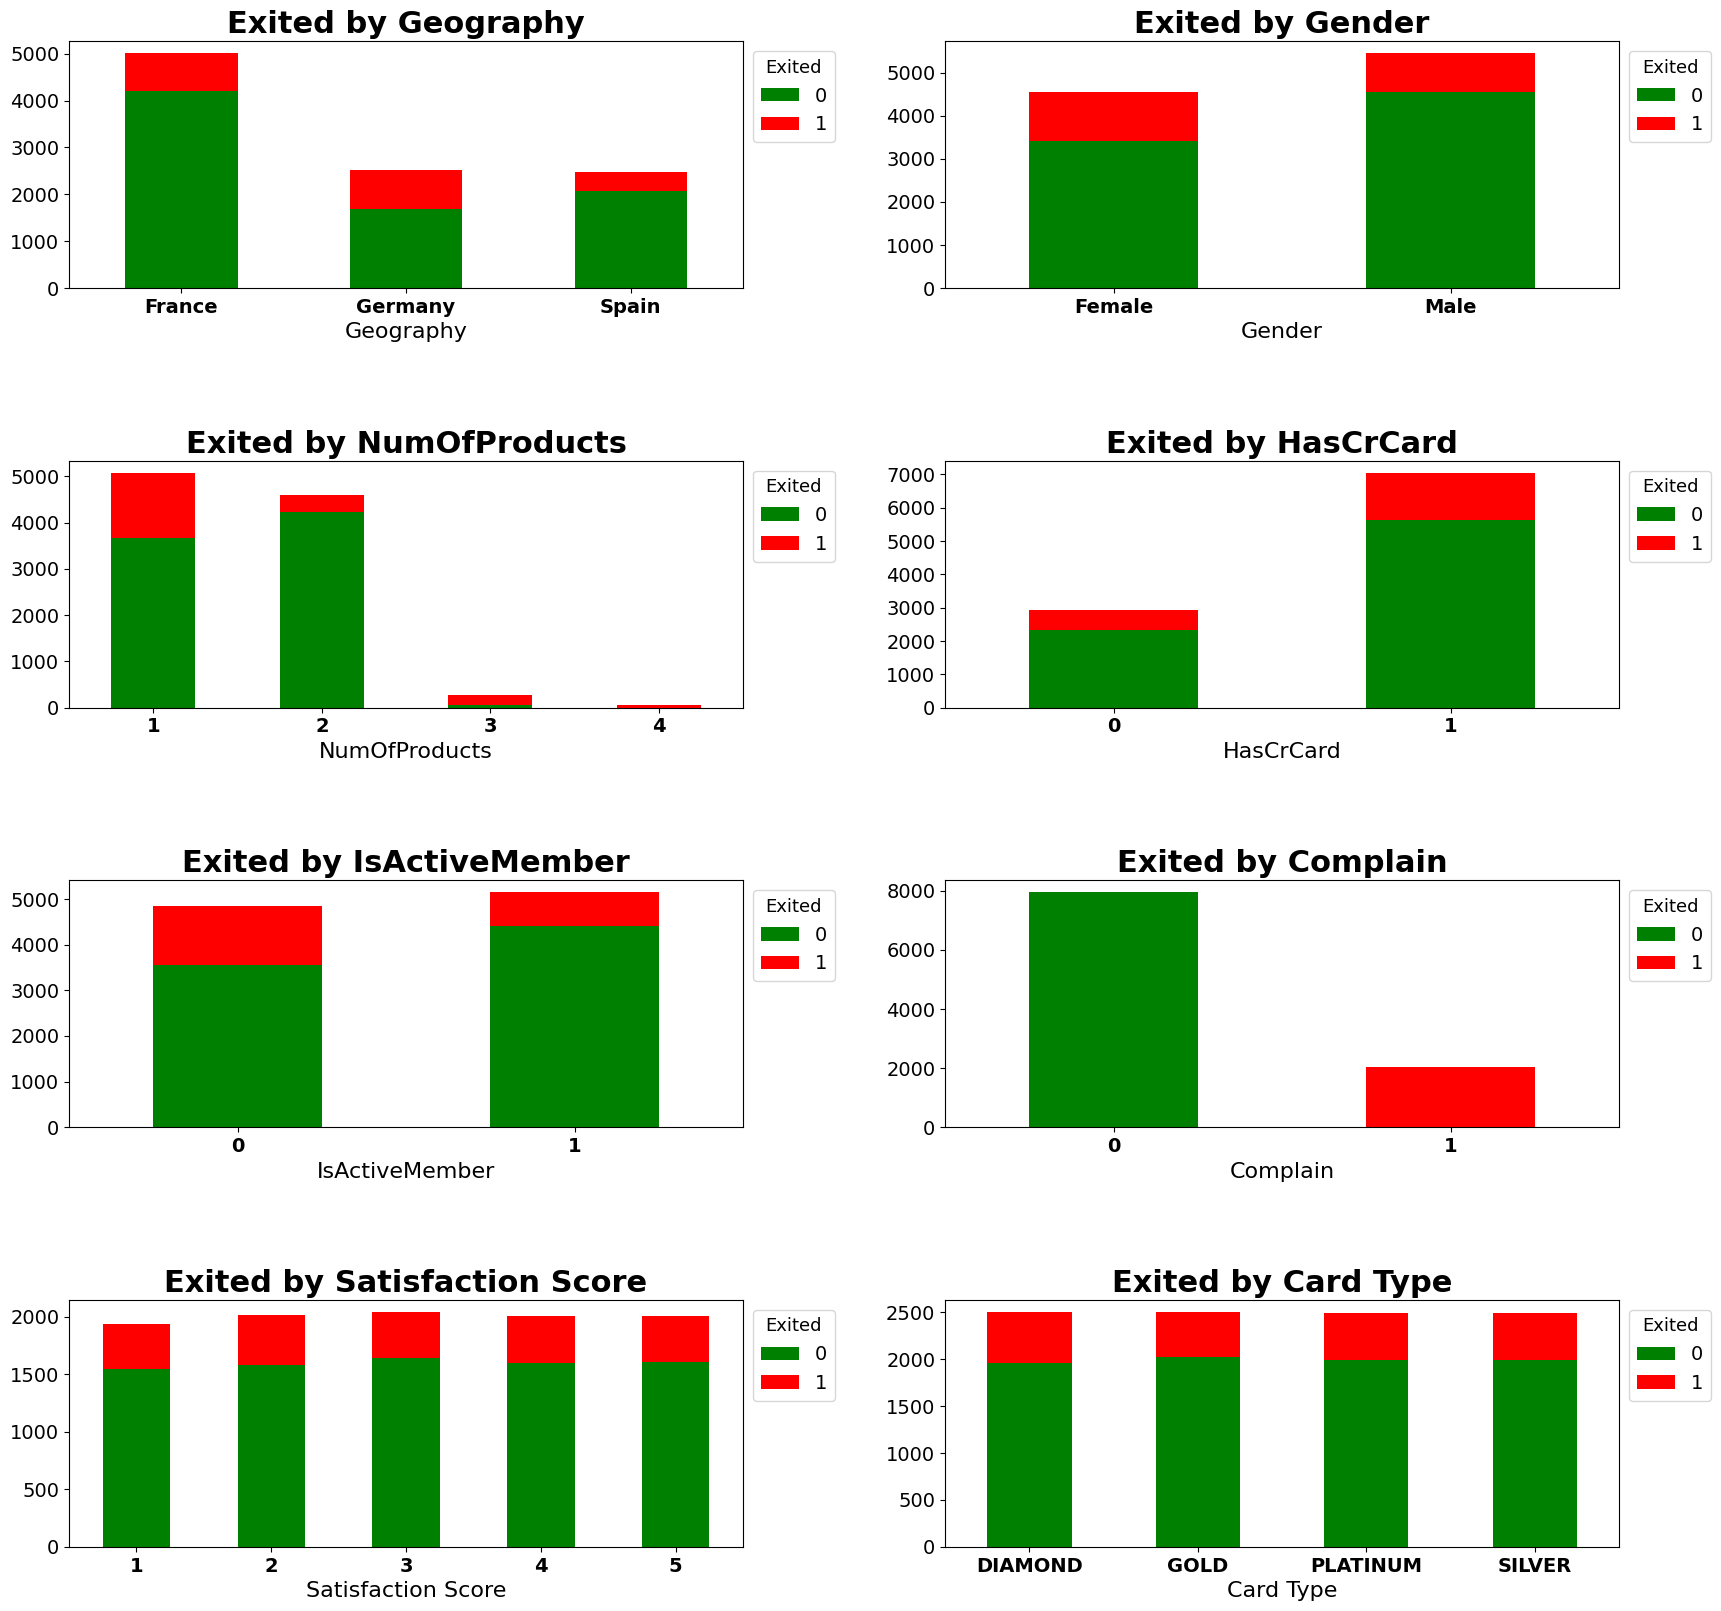

In [8]:
#%% Variável alvo em relação as demais variáveis 





plt.figure(figsize=(20, 25)) #tamanho do painel grafico

#funcao de adicao de legenda no canto superior direito e garante rotulos 
def add_legend(ax):
    
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        
        # Se não houver handles, forca a adicao
        handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['green', 'red']]
        labels = ['Not Exited', 'Exited']
        
    # Adiciona a legenda fora da área das barras
    ax.legend(handles, labels, loc='upper left', fontsize=14, title='Exited', title_fontsize='13',  
              bbox_to_anchor=(1.0, 1)) 




# Geography
plt.subplot(5, 2, 1)
counts = base_original.groupby(['Geography', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Geography', fontsize=22, fontweight='bold')
plt.xlabel('Geography', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Gender
plt.subplot(5, 2, 2)
counts = base_original.groupby(['Gender', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by Gender', fontsize=22, fontweight='bold')
plt.xlabel('Gender', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# NumOfProducts
plt.subplot(5, 2, 3)
counts = base_original.groupby(['NumOfProducts', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by NumOfProducts', fontsize=22, fontweight='bold')
plt.xlabel('NumOfProducts', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# HasCrCard
plt.subplot(5, 2, 4)
counts = base_original.groupby(['HasCrCard', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by HasCrCard', fontsize=22, fontweight='bold')
plt.xlabel('HasCrCard', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# IsActiveMember
plt.subplot(5, 2, 5)
counts = base_original.groupby(['IsActiveMember', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by IsActiveMember', fontsize=22, fontweight='bold')
plt.xlabel('IsActiveMember', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Complain
plt.subplot(5, 2, 6)
counts = base_original.groupby(['Complain', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Complain', fontsize=22, fontweight='bold')
plt.xlabel('Complain', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Satisfaction Score
plt.subplot(5, 2, 7)
counts = base_original.groupby(['Satisfaction Score', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Satisfaction Score', fontsize=22, fontweight='bold')
plt.xlabel('Satisfaction Score', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Card Type
plt.subplot(5, 2, 8)
counts = base_original.groupby(['Card Type', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Card Type', fontsize=22, fontweight='bold')
plt.xlabel('Card Type', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Ajusta a distância entre os gráficos
plt.subplots_adjust(hspace=0.7, wspace=0.3)

# Variaveis Dummies

* A maioria dos modelos necessita de transformar as variaveis categoricas em numericas, e o modelo MLP (Multilayer Perceptron) e um deles; 

* A transformacao de categoricas em numericas precisa ser feita com processos adequados para nao cometer ponderacao arbitrária no desenvolvimento. 

* foi aplicado one-hot encoding para isso. Esse processo e chamado de "Dummizacao". 
 

In [9]:
# Dumizando

# Suprime todos os warnings de futuro (deixa mais clean) 
warnings.filterwarnings('ignore', category=FutureWarning)



# Lista de variaveis a serem transformadas
cols_to_transform = ['HasCrCard', 'IsActiveMember', 'Geography', 'Gender', 'Card Type']

# Convertendo para string
df.loc[:, cols_to_transform] = df.loc[:, cols_to_transform].astype(str)

# one-hot encoding 
df_dummies = pd.get_dummies(df, columns=cols_to_transform, dtype=int, drop_first=False)



# variável alvo 'Exited' para o tipo numérico, pois o modelo requer isso de todas as varaiveis (por isso dumizar)
df_dummies['Exited'] = df_dummies['Exited'].astype('int64')

print(df_dummies.dtypes)

CreditScore             int64
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
EstimatedSalary       float64
Complain                int64
Satisfaction Score      int64
Point Earned            int64
Exited                  int64
HasCrCard_0             int64
HasCrCard_1             int64
IsActiveMember_0        int64
IsActiveMember_1        int64
Geography_France        int64
Geography_Germany       int64
Geography_Spain         int64
Gender_Female           int64
Gender_Male             int64
Card Type_DIAMOND       int64
Card Type_GOLD          int64
Card Type_PLATINUM      int64
Card Type_SILVER        int64
dtype: object


# Separação Treino e Teste & Adicao de Features quadráticas

* A separacao em treino e teste alem de uma boa pratica e extreamente necessario na construcao de modelos de machine learning; 

* Tambem foram adicionadas variaveis quadraticas, ou seja, com operacao matematica aplicadas em variaveis originais gerando novas variaveis. Isso foi feito para capturar algum tipo de comportamento nao linear; 

* Foi considerado aplicar transformacao polinomial nas variaveis, por isso foi primeiro aplicado o termo quadratico, que nao apresentou melhoria significativa a ponto de aplicarmos polinomias; 

* Alem disso MLPs capturam naturalmente comportamentos nao lineares. O termo quadratico foi util para validacao durante o estudo mas a melhoria foi baixa, por isso mantemos apenas os termos quadraticos sem incluir interacoes entre variaveis (seria aplicacao Polinomias completo); 



* Tambem e possivel notar o desbalanceamento das classes  nas bases tanto em treino quanto em teste no grafico final; 

* Tambem garantimos a mesma proporcao (80/20) tanto em treino quanto em teste na separacao das bases , ou seja, equidade de divisao de dados e equilibrio. 


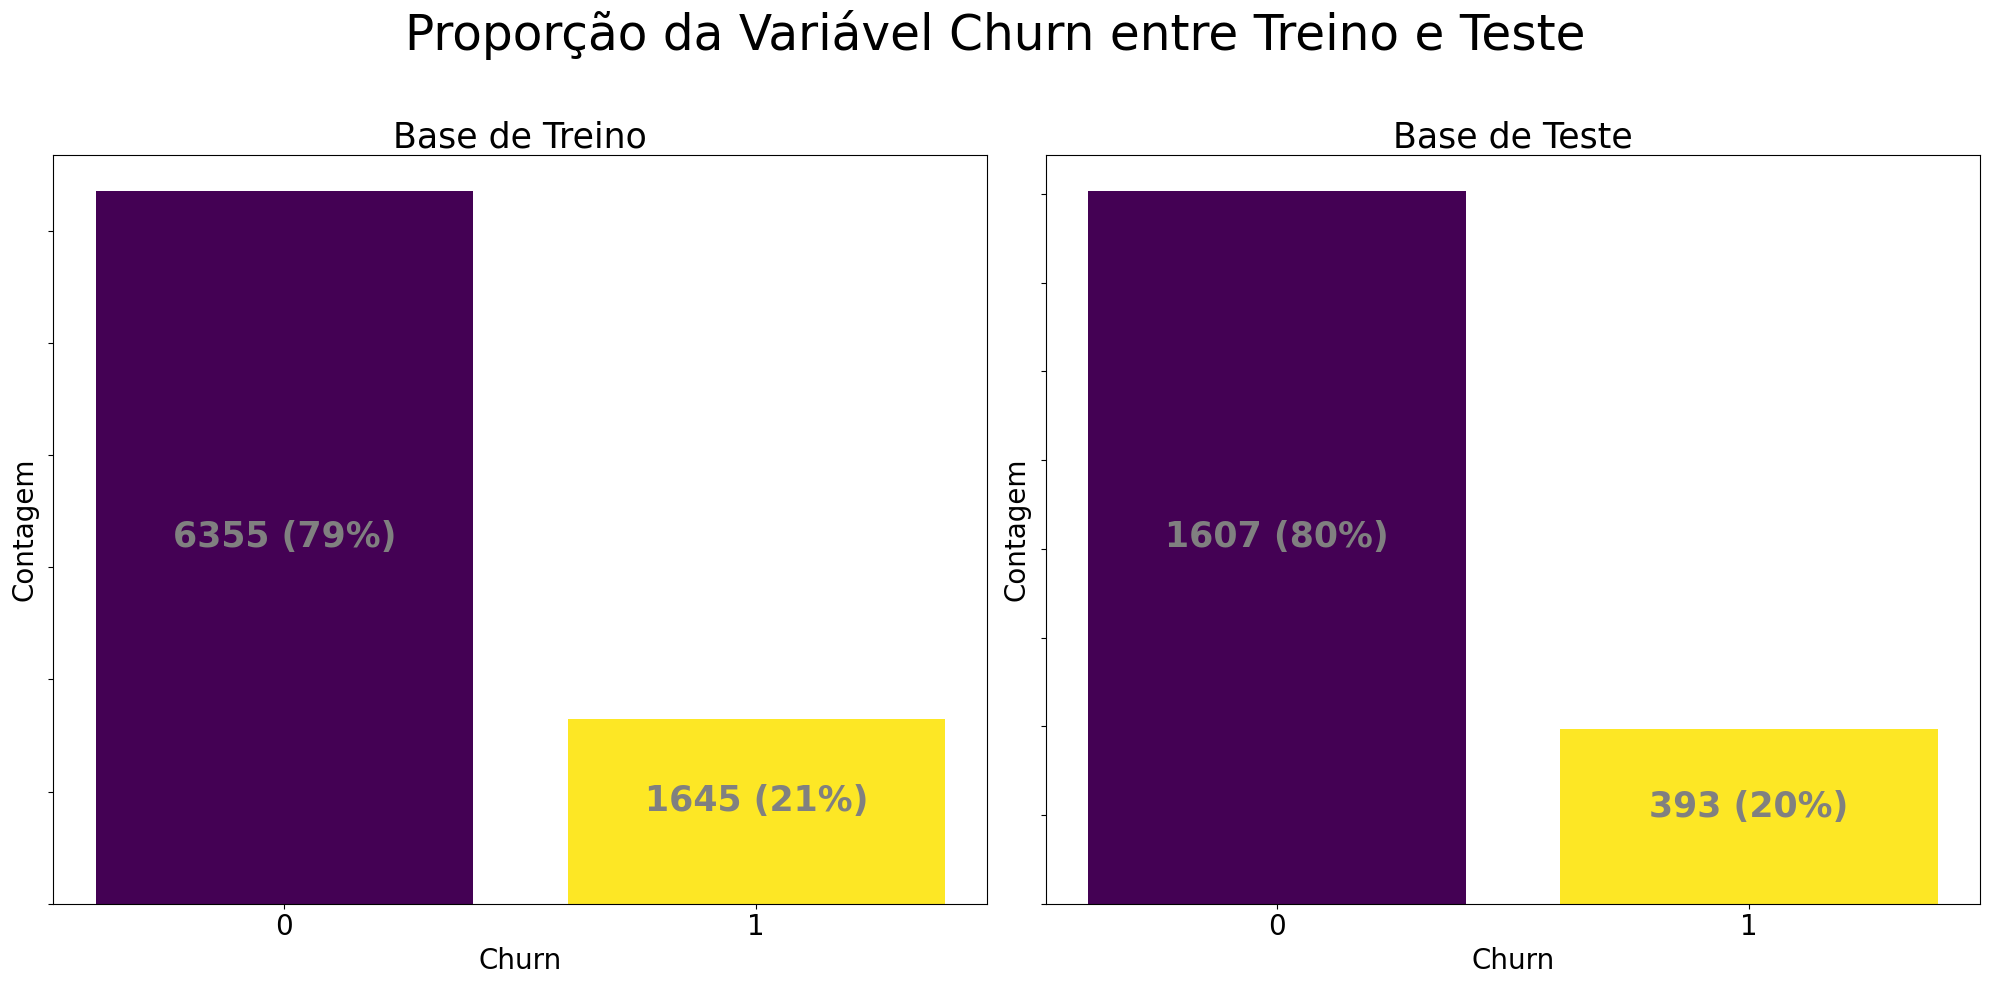

In [10]:
#X ---> Variáveis explicativas 
#Y ---> Evento de estudo (variável TARGET, evento de estudo, ^y etc..)

df_dummies = df_dummies.drop(columns=['Complain'])


X = df_dummies .drop('Exited', axis=1)

# VARIAVEIS QUADRATICAS 
X['Balance_Squared'] = X['Balance'] ** 2
X['Age_Squared'] = X['Age'] ** 2
X['CreditScore_Squared'] = X['CreditScore'] ** 2
X['NumOfProducts_Squared'] = X['NumOfProducts'] ** 2
X['Tenure_Squared'] = X['Tenure'] ** 2
X['EstimatedSalary_Squared'] = X['EstimatedSalary'] ** 2



y =  df_dummies['Exited']


#separando em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Visualizando a proporção de eventos de churn (TARGET) nas bases de TREINO e TESTE 

# Contando os valores 
churn_counts_train = y_train.value_counts()
churn_counts_test = y_test.value_counts()


# plot que contem os graficos
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Proporção da Variável Churn entre Treino e Teste', fontsize=35)  
cmap = plt.get_cmap('viridis', 2) #paleta de cores



# Gráfico da base de treino
bars_train = axs[0].bar(churn_counts_train.index, churn_counts_train.values, color=cmap(range(2)))
axs[0].set_title('Base de Treino', fontsize=25)
axs[0].set_xlabel('Churn', fontsize=20)
axs[0].set_ylabel('Contagem', fontsize=20)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0', '1'], fontsize=20)
axs[0].set_yticklabels([]) # Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_train = churn_counts_train.sum()
for bar in bars_train:
    count = int(bar.get_height())
    percentage = round(count / total_train * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')




# Gráfico da base de teste
bars_test = axs[1].bar(churn_counts_test.index, churn_counts_test.values, color=cmap(range(2)))
axs[1].set_title('Base de Teste', fontsize=25)
axs[1].set_xlabel('Churn', fontsize=20)
axs[1].set_ylabel('Contagem', fontsize=20)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['0', '1'], fontsize=20)
axs[1].set_yticklabels([])# Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_test = churn_counts_test.sum()
for bar in bars_test:
    count = int(bar.get_height())
    percentage = round(count / total_test * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')



# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # forca espaco para o titulo
plt.show()




# Verificando correlacoes depois de construcao total de features e Dummizacao 

* Verificar as correlacoes e extreammente importante, elas podem indicar a famosa multicolinearidade, que atrapalha a maioria dos modelos; 

* no caso da MLP (pelo menos a presente aplicacao) ela nao afetou, a observei com atencao, mas nao impactou. Decidi manter as variveis mesmo com multicolinearidade em algumas (nao se assuste). 



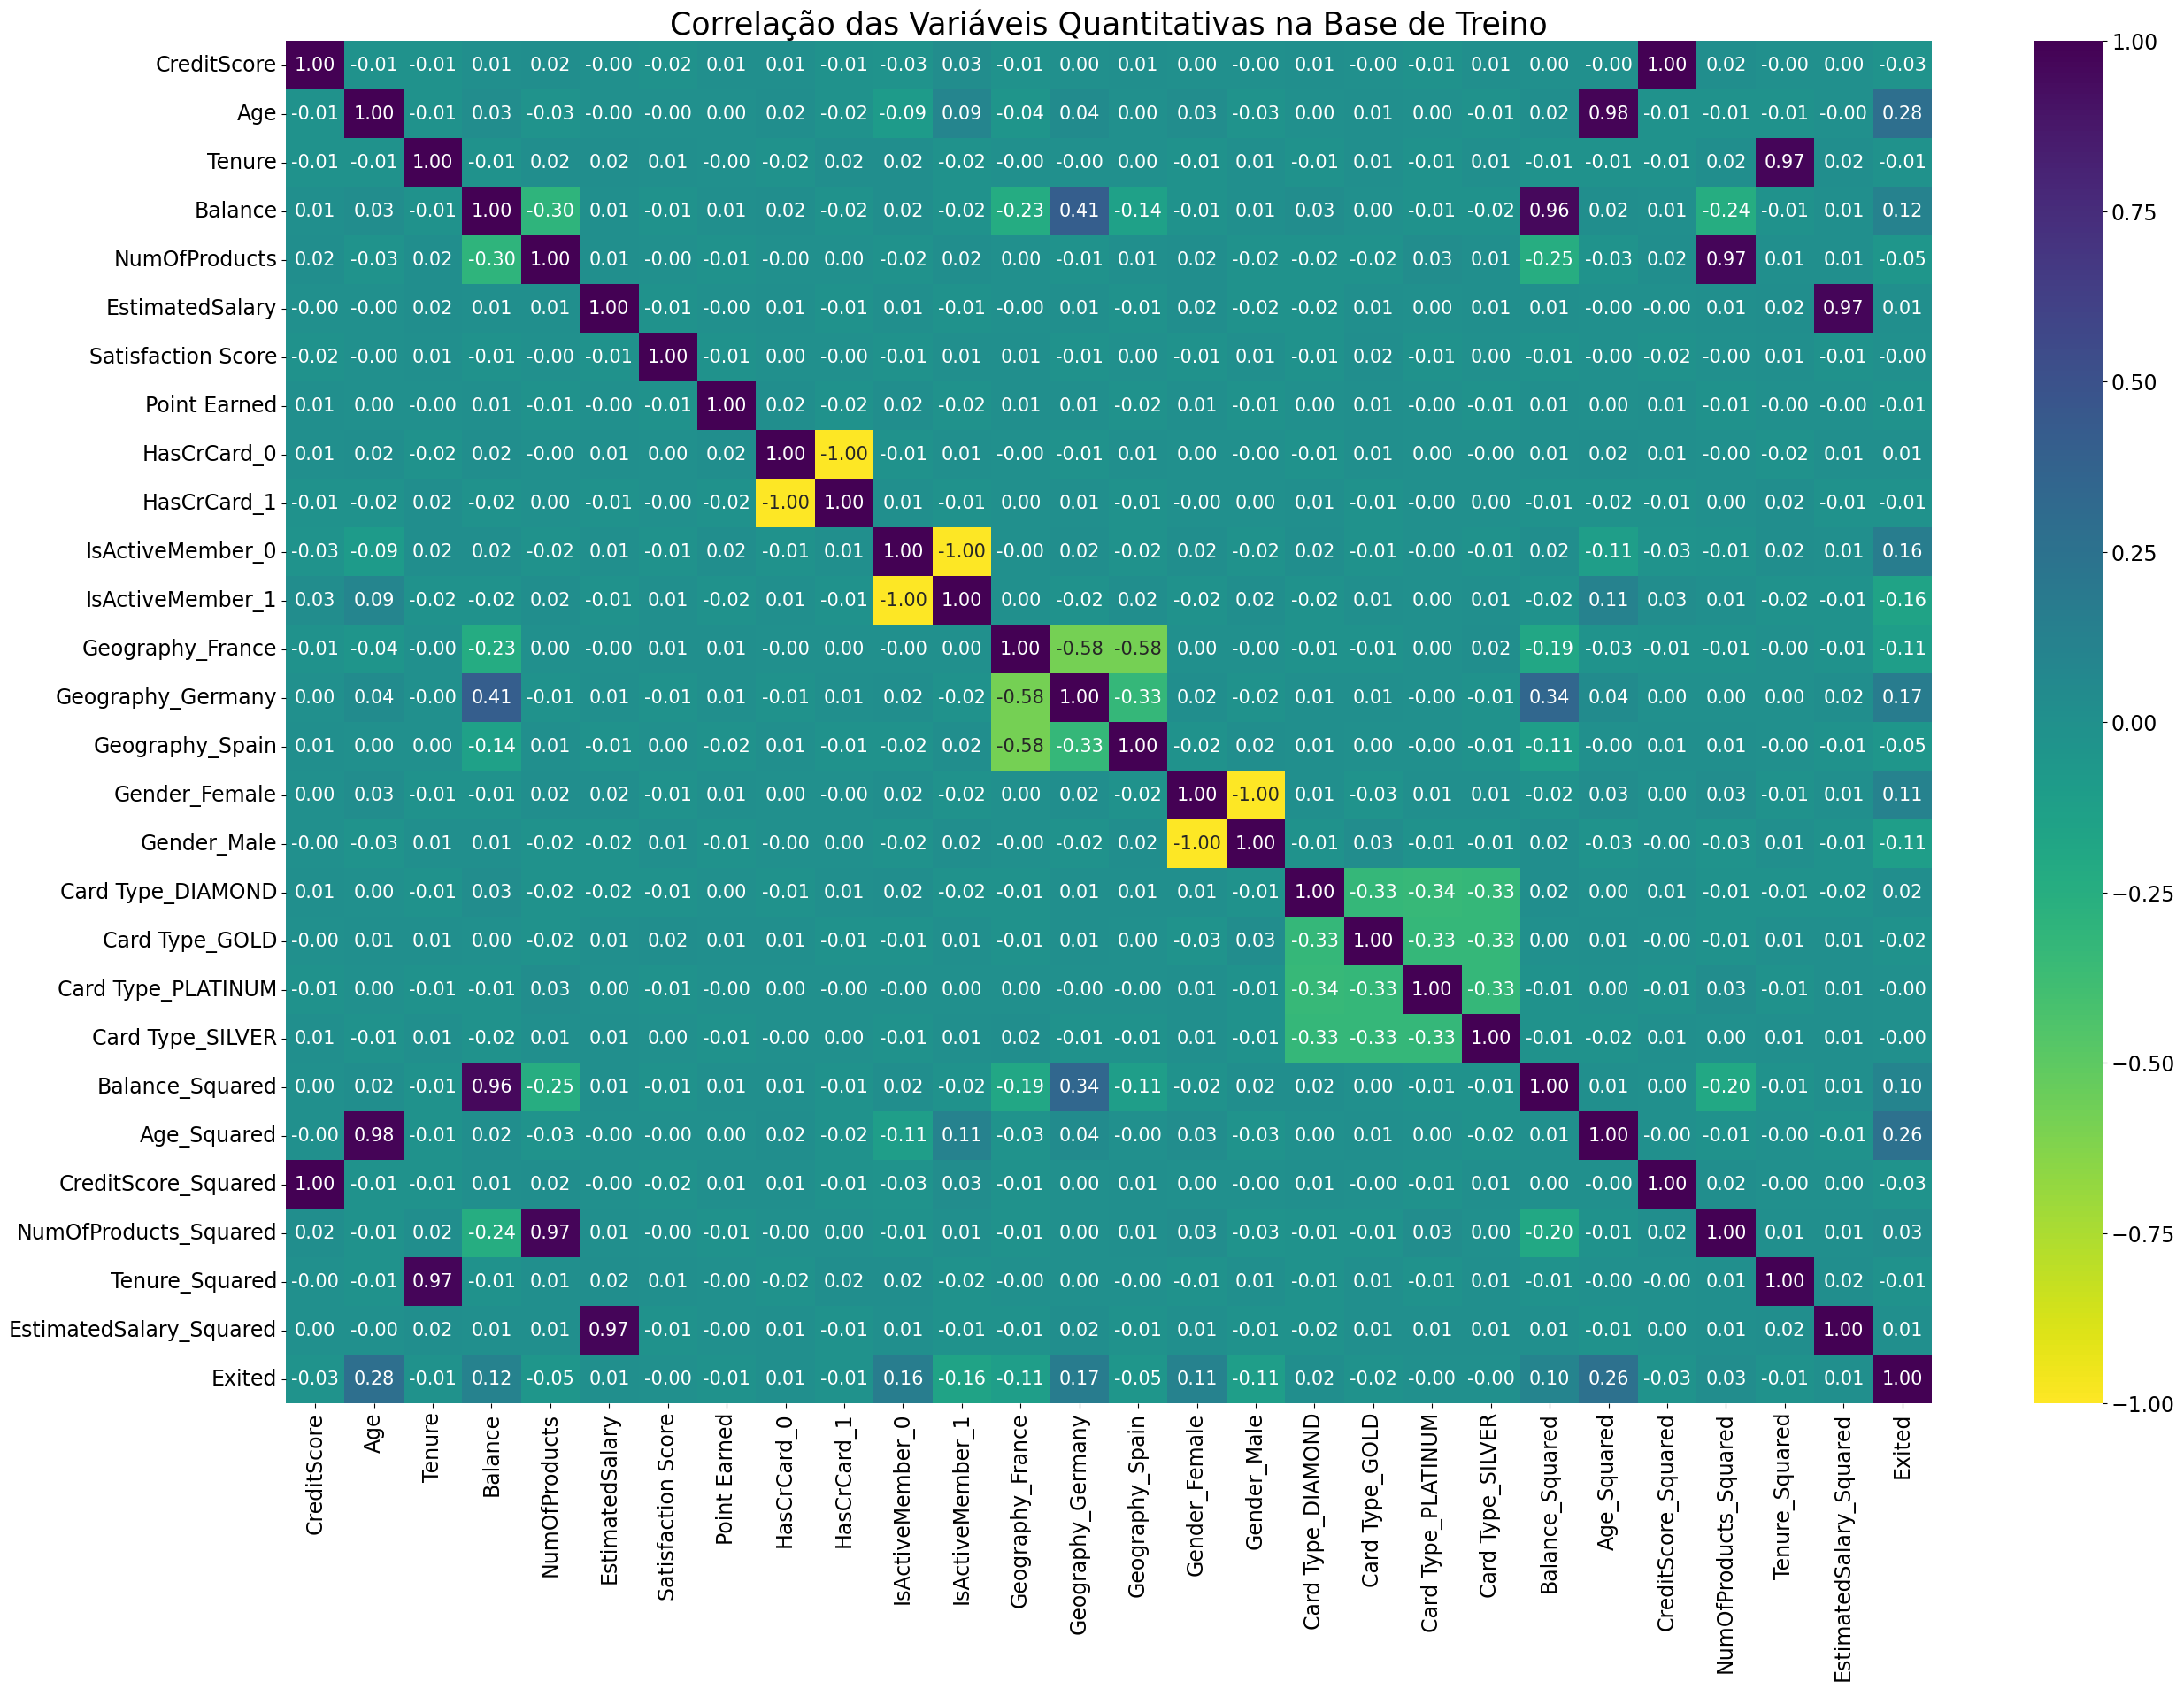

In [11]:
#Observando Multicolinearidade na base de treino

teste_multco_treino = pd.concat([X_train,y_train], axis = 1)

correlation_matrix_treino = teste_multco_treino.corr().round(2)
correlation_matrix_treino

# Matrix com  mapa de calor 
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix_treino, annot=True, fmt=".2f",
                      cmap=plt.cm.viridis_r, # paleta de cores viridis (ou viridis_r para o inverso de cores) é uma paleta especial 
                                             # para facilitar a visualizacao por pessoas com dificuldades visuais, como os daltonicos. 
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
plt.title('Correlação das Variáveis Quantitativas na Base de Treino',fontsize=25)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# Analise e tratamento de Outliers 

* Outliers sao numericos e podem afetar de diversas formas modelos de MLP porque eles utilizam backpropagation e descida do gradiente, entre outras coisas que podem atrapalhar a capacidade preditiva do modelo; 

* para resolver sem perder dados, pois temos poucas observcoes para estudo, nao foram removidos como facilmente poderia fazer-se, ao inves foi aplicado winsorization; 

* winsorization e uma tecnica de limitacao dos outliers, ela substiui os valores de outlierns pelos limites superiores e inferiores; 

* Para isso, e calculado um intervalo de valores aceitos com base no primeiro quartil (Q1) e no terceiro quartil (Q3), valores abaixo do limite inferior ou acima do limite superior sao ajustados para os respectivos limites, corrigindo assim os outliers 

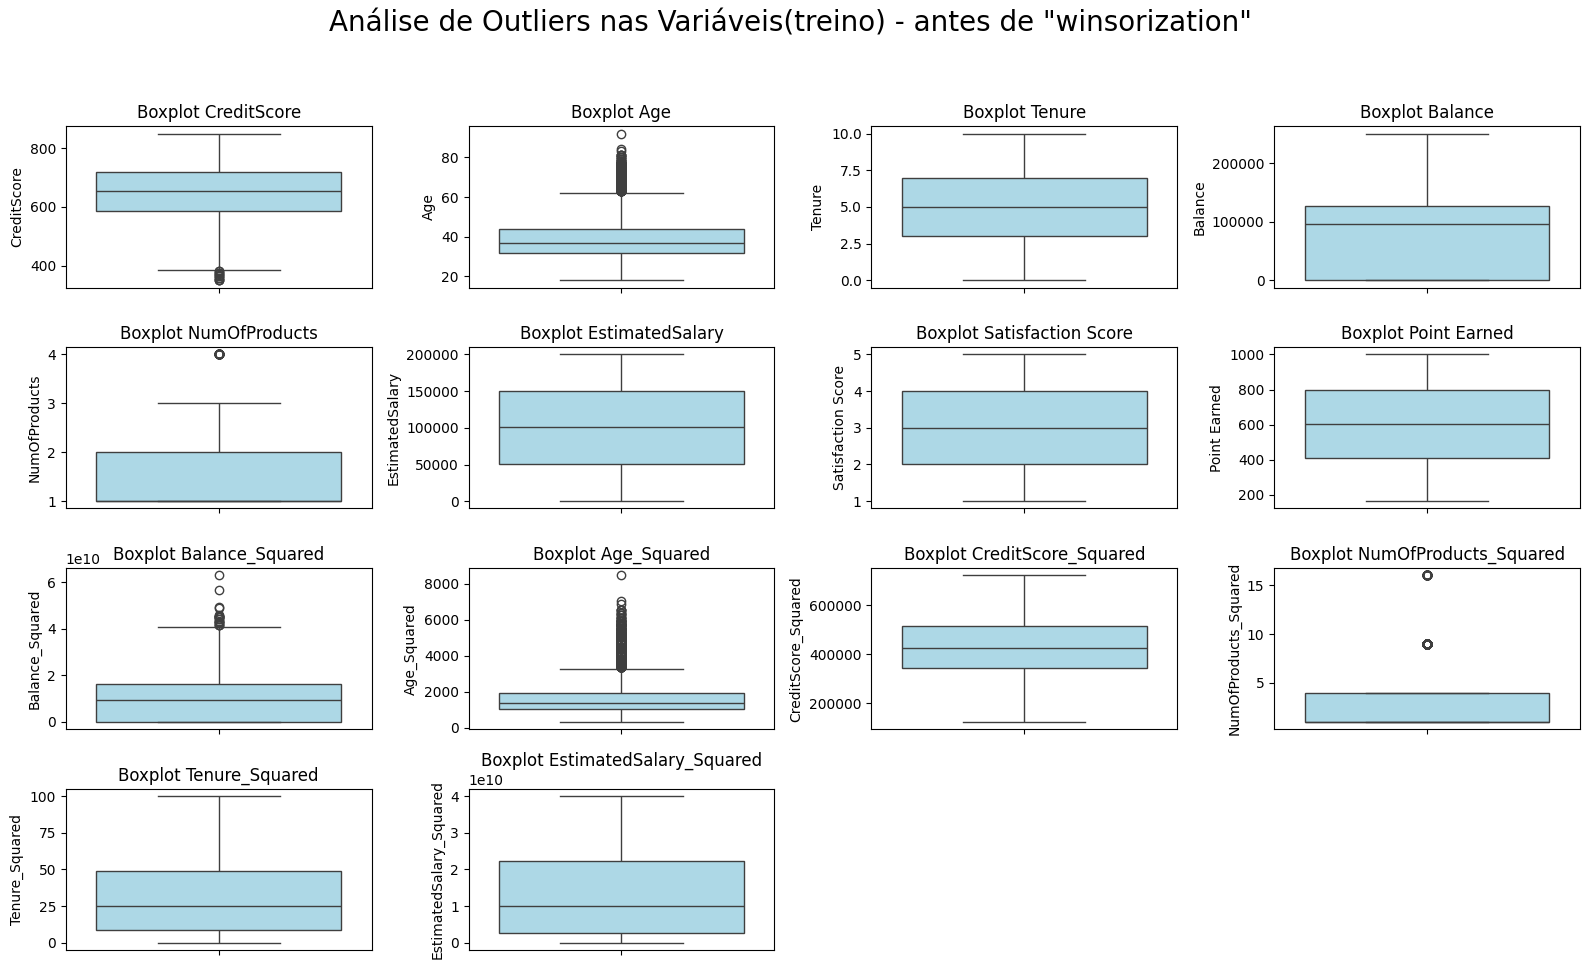

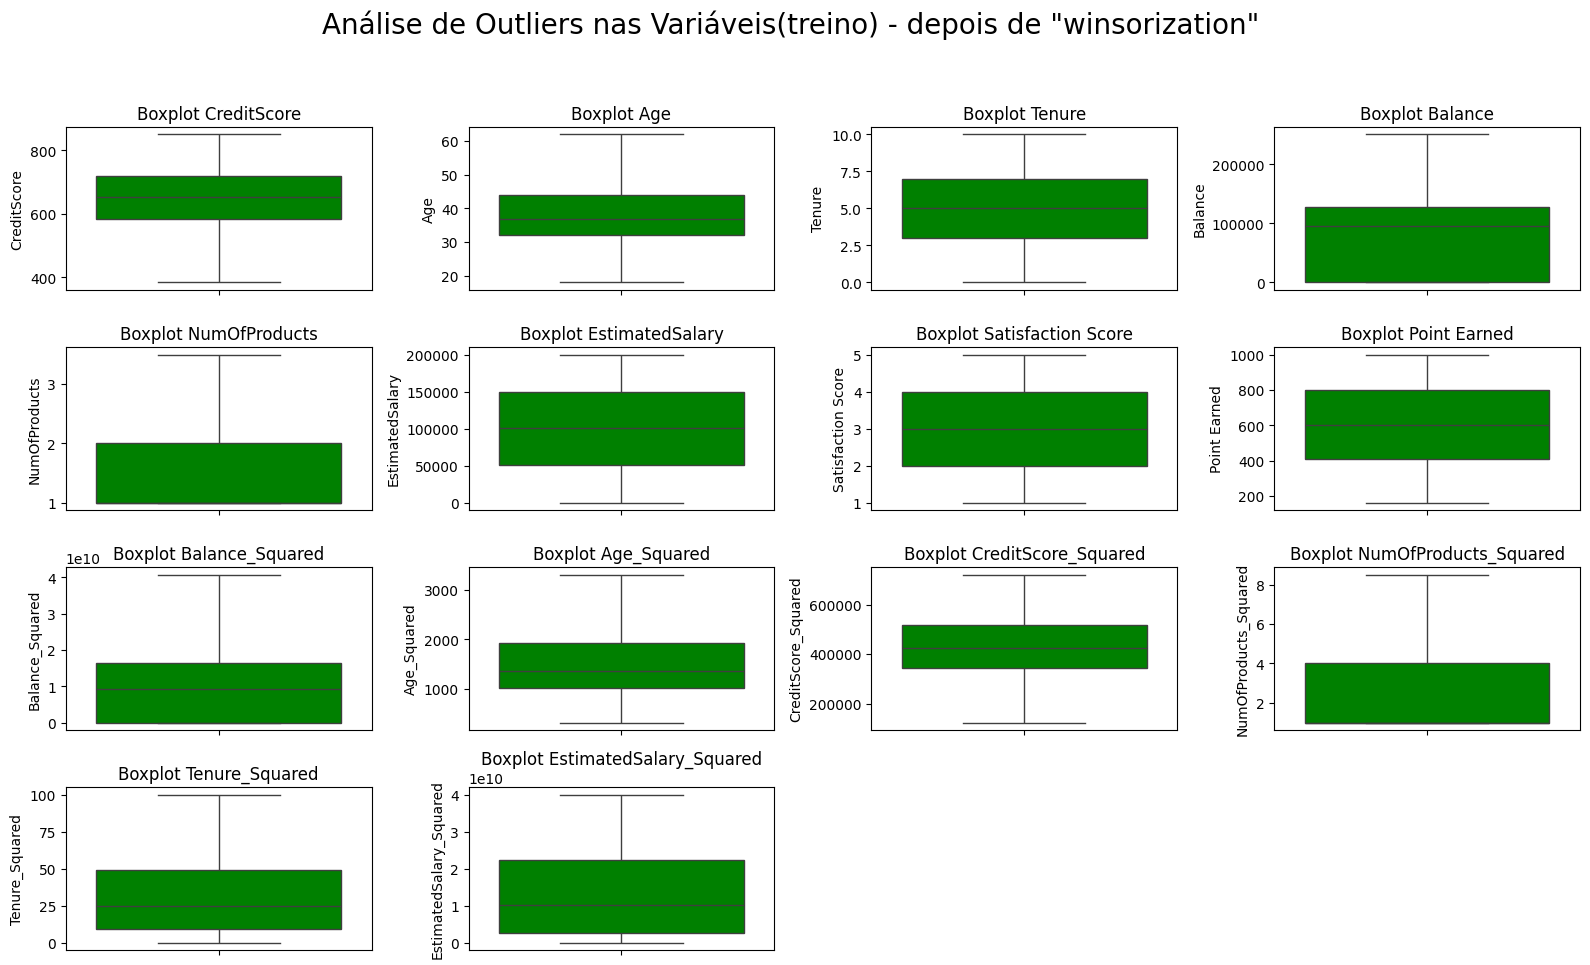

In [12]:
#%% analise de outliers das variaveis na base de treino 


###############antes de tratamento############################# 
variaveis = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'EstimatedSalary',
    'Satisfaction Score',
    'Point Earned',
    #QUADRATICAS
    'Balance_Squared',
    'Age_Squared',
    'CreditScore_Squared',
    'NumOfProducts_Squared',
    'Tenure_Squared',
    'EstimatedSalary_Squared'
]


# definindo tamnhos de subplots 
plt.figure(figsize=(16, 12))

# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='lightblue'))  # Cor interna do boxplot 
    plt.title(f'Boxplot {var}', fontsize=12)
    
#  título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - antes de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajuste de layout
plt.show()
###############################################################






# Função que aplica winsorization
def tratar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Substitui outliers pelo limite inferior ou superior
    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])





###############depois de tratamento############################# 

# Aplicando a função nas variáveis 
variaveis_para_tratar = ['CreditScore',
                        'Age',
                        'Tenure',
                        'Balance',
                        'NumOfProducts',
                        'EstimatedSalary',
                        'Satisfaction Score',
                        'Point Earned',
                        #QUADRATICAS
                        'Balance_Squared',
                        'Age_Squared',
                        'CreditScore_Squared',
                        'NumOfProducts_Squared',
                        'Tenure_Squared',
                        'EstimatedSalary_Squared'
                         ]
for variavel in variaveis_para_tratar:
    tratar_outliers(teste_multco_treino, variavel)


# subplot
plt.figure(figsize=(16, 12))



# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='green'))  # Cor interna do boxplot
    plt.title(f'Boxplot {var}', fontsize=12)
########################################################################


# título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - depois de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # ajusta layout
plt.show()

In [13]:
#BASE DE TREINO 
teste_multco_treino

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Balance_Squared,Age_Squared,CreditScore_Squared,NumOfProducts_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
9254,686.0,32.0,6.0,0.00,2.0,179093.26,2.0,510.0,0,1,0,1,1,0,0,0,1,1,0,0,0,0.000000e+00,1024.0,470596.0,4.0,36.0,3.207440e+10,0
1561,632.0,42.0,4.0,119624.60,2.0,195978.86,4.0,959.0,0,1,0,1,0,1,0,0,1,0,0,1,0,1.431004e+10,1764.0,399424.0,4.0,16.0,3.840771e+10,0
1670,559.0,24.0,3.0,114739.92,1.0,85891.02,4.0,327.0,0,1,1,0,0,0,1,0,1,0,0,0,1,1.316525e+10,576.0,312481.0,1.0,9.0,7.377267e+09,1
6087,561.0,27.0,9.0,135637.00,1.0,153080.40,2.0,567.0,0,1,1,0,1,0,0,1,0,0,0,0,1,1.839740e+10,729.0,314721.0,1.0,81.0,2.343361e+10,1
6669,517.0,56.0,9.0,142147.32,1.0,39488.04,3.0,727.0,1,0,1,0,1,0,0,0,1,0,0,1,0,2.020586e+10,3136.0,267289.0,1.0,81.0,1.559305e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,768.0,54.0,8.0,69712.74,1.0,69381.05,3.0,569.0,0,1,0,1,1,0,0,0,1,0,0,0,1,4.859866e+09,2916.0,589824.0,1.0,64.0,4.813730e+09,0
5191,682.0,58.0,1.0,0.00,1.0,706.50,4.0,709.0,0,1,0,1,1,0,0,1,0,0,0,1,0,0.000000e+00,3304.0,465124.0,1.0,1.0,4.991422e+05,0
5390,735.0,38.0,1.0,0.00,3.0,92220.12,5.0,678.0,1,0,1,0,1,0,0,1,0,0,0,0,1,0.000000e+00,1444.0,540225.0,8.5,1.0,8.504551e+09,1
860,667.0,43.0,8.0,190227.46,1.0,97508.04,3.0,680.0,0,1,1,0,1,0,0,0,1,1,0,0,0,3.618649e+10,1849.0,444889.0,1.0,64.0,9.507818e+09,1


In [14]:
# BASE DE TESTE
base_corrige_teste = pd.concat([X_test,y_test], axis = 1)
base_corrige_teste


,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Balance_Squared,Age_Squared,CreditScore_Squared,NumOfProducts_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
6252,596,32,3,96709.07,2,41788.37,1,709,1,0,1,0,0,1,0,0,1,0,1,0,0,9.352644e+09,1024,355216,4,9,1.746268e+09,0
4684,623,43,1,0.00,2,146379.30,2,508,0,1,0,1,1,0,0,0,1,0,0,0,1,0.000000e+00,1849,388129,4,1,2.142690e+10,0
1731,601,44,4,0.00,2,58561.31,1,281,0,1,1,0,0,0,1,1,0,0,1,0,0,0.000000e+00,1936,361201,4,16,3.429427e+09,0
4742,506,59,8,119152.10,2,170679.74,2,979,0,1,0,1,0,1,0,0,1,0,0,0,1,1.419722e+10,3481,256036,4,64,2.913157e+10,0
4521,560,27,7,124995.98,1,114669.79,5,457,0,1,0,1,0,0,1,1,0,0,0,0,1,1.562400e+10,729,313600,1,49,1.314916e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,602,53,5,98268.84,1,45038.29,5,813,1,0,0,1,0,1,0,1,0,0,0,1,0,9.656765e+09,2809,362404,1,25,2.028448e+09,1
8285,609,25,10,0.00,1,109895.16,2,652,1,0,0,1,1,0,0,0,1,0,0,1,0,0.000000e+00,625,370881,1,100,1.207695e+10,0
7853,730,47,7,0.00,1,33373.26,2,504,0,1,1,0,1,0,0,1,0,0,0,1,0,0.000000e+00,2209,532900,1,49,1.113774e+09,1
1095,692,29,4,0.00,1,76755.99,3,686,0,1,1,0,1,0,0,0,1,0,0,1,0,0.000000e+00,841,478864,1,16,5.891482e+09,1


# Preparacao dos dados  


* Preparacao dos dados 


------------------------
 DATA Prep
------------------------
------------------------
Início: 2025-02-09 00:20:22.493135
------------------------
Índices de X_test e y_test já estavam alinhados.


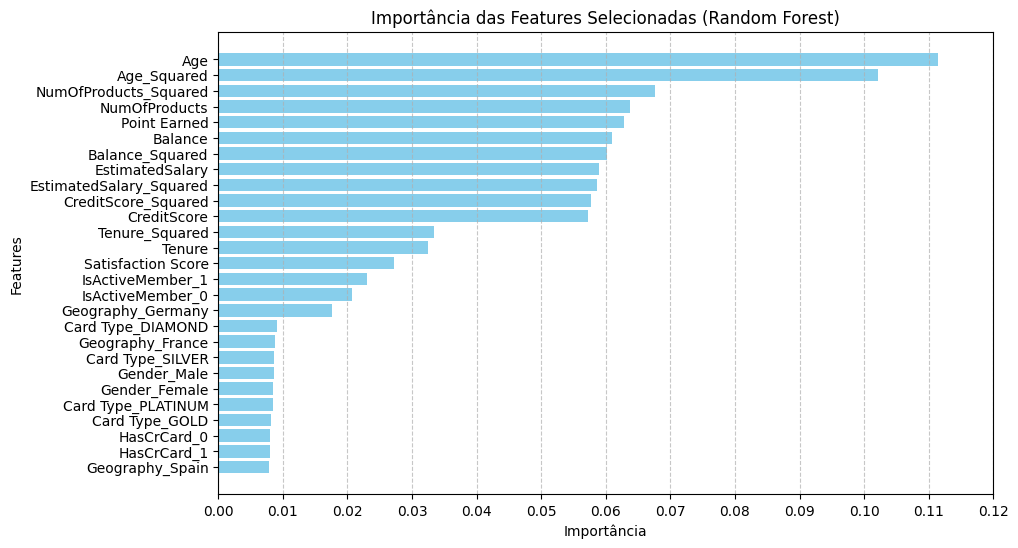

X_train_scaled: 8000
X_train_scaled: 8000
X_test_scaled: 2000


In [15]:
print('------------------------')
print(" DATA Prep")
print('------------------------')

# Desativando os warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
warnings.filterwarnings("ignore", category=UserWarning, module='optuna')
warnings.filterwarnings("ignore", category=FutureWarning, module='optuna')
warnings.filterwarnings('ignore', category=DeprecationWarning)
logging.getLogger("optuna").setLevel(logging.CRITICAL)



# início
start_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print('------------------------')


######################################## PRE-PROCESSAMENTO E PREPARACAO NOS DADOS ################################################################### 



# Defini variáveis de treinamento
X_train = teste_multco_treino.drop('Exited', axis=1)
y_train = teste_multco_treino['Exited']

# Verifica e conserta desalinhamento de índices caso tenha (X_test e y_test)
if not X_test.index.equals(y_test.index):
    print("Índices de X_test e y_test não estavam alinhados. Realinhando y_test.")
    y_test = y_test.loc[X_test.index]
else:
    print("Índices de X_test e y_test já estavam alinhados.")

# Concatena os dados corrigidos para criar a base de teste
base_corrige_teste = pd.concat([X_test, y_test], axis=1)

# Redefini X_test e y_test com índices corrigidos e verificados
X_test = base_corrige_teste.drop('Exited', axis=1)
y_test = base_corrige_teste['Exited']




# Criar e treinar o modelo Random Forest para selecionar as melhores variaveis 


#detalhe importante, nao tem predict(), somente o fit() 


rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Obter a importância das features
feature_importances = rf.feature_importances_

# Criar DataFrame com os nomes das features e suas importâncias
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Filtrar features com importância maior que 0.01 (ou outro threshold desejado)
selected_features = feature_df[feature_df['Importance'] > 0.01]['Feature'].tolist()

# Ordenar as features pela importância (do menor para o maior)
feature_df = feature_df.sort_values(by='Importance', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features Selecionadas (Random Forest)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, max(feature_df['Importance'])+0.01, 0.01))


# Mostrar o gráfico
plt.show()

# Aplicar a seleção das mesmas features ao conjunto de treino e teste
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]



# Escalonamento dos dados
# scalers a testar   (StandardScaler, MinMaxScaler, RobustScaler)
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()

# Escalonar os dados de treino e teste selecionados
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


print('X_train_scaled:',X_train_scaled.shape[0])
print('X_train_scaled:',X_train_scaled.shape[0])
print('X_test_scaled:',X_test_scaled.shape[0])





# XGboost

In [16]:
# Configurações

print("##############  Modelagem  ##########################")


print('------------------------')
print("XGboost")
print('------------------------')



print("Shape X_train_scaled:", X_train_scaled.shape)
print("Shape y_train:", y_train.shape)


warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)


start_time_utc = datetime.utcnow() - timedelta(hours=3)
print("Tempo de Início:", start_time_utc)
print('------------------------')


#antes era apliacado smote aqui mas, 
#Aplicar SMOTE ( ou qualquyer tecnica de sampling ) antes da validação cruzada causa vazamento de dados(data leakage);

#data leakage: ocorre quando daos de teste são inadvertidamente usadas para treinar o modelo (dai o chamado vazamento)


X_train_resampled, y_train_resampled = X_train_scaled , y_train

print("Shape X_train_resampled:", X_train_resampled.shape)
print("Shape y_train_resampled:", y_train_resampled.shape)

assert X_train_resampled.shape[0] == y_train_resampled.shape[0], "Erro: Número de amostras não coincide"


##############  Modelagem  ##########################
------------------------
XGboost
------------------------
Shape X_train_scaled: (8000, 17)
Shape y_train: (8000,)
Tempo de Início: 2025-02-09 00:20:26.092238
------------------------
Shape X_train_resampled: (8000, 17)
Shape y_train_resampled: (8000,)


Usando GPU: True


Otimização em andamento: 100%|██████████| 100/100 [25:27<00:00, 15.28s/trial]


📊 MELHORES HIPERPARÂMETROS ENCONTRADOS
════════════════════════════════════════════════════════════
Hiperparâmetro           Valor          
────────────────────────────────────────────────────────────
booster                  dart           
objective                binary:logistic
eval_metric              auc            
learning_rate            0.04918591360453736
n_estimators             89             
max_depth                5              
min_child_weight         1              
subsample                0.8501764220901958
colsample_bytree         0.6819924364628454
colsample_bylevel        0.8432629525369784
colsample_bynode         0.6881489615213574
gamma                    0.03072128263190782
lambda                   0.17175075774530368
alpha                    0.23412613085498613
scale_pos_weight         1              
max_delta_step           0.015698538332368242
early_stopping_rounds    31             
tree_method              gpu_hist       
grow_policy              lo

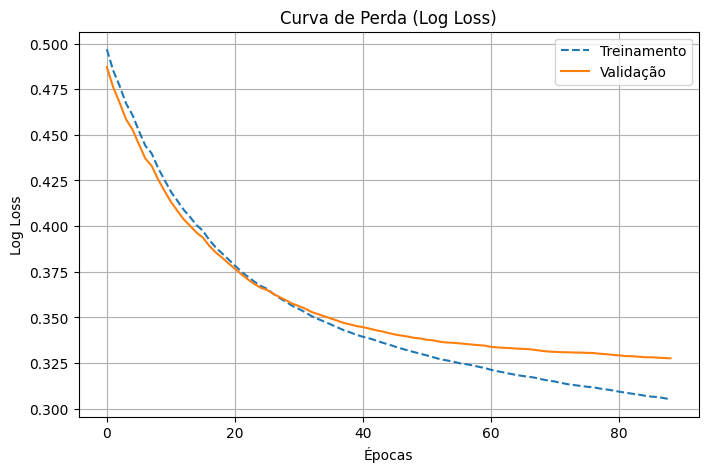

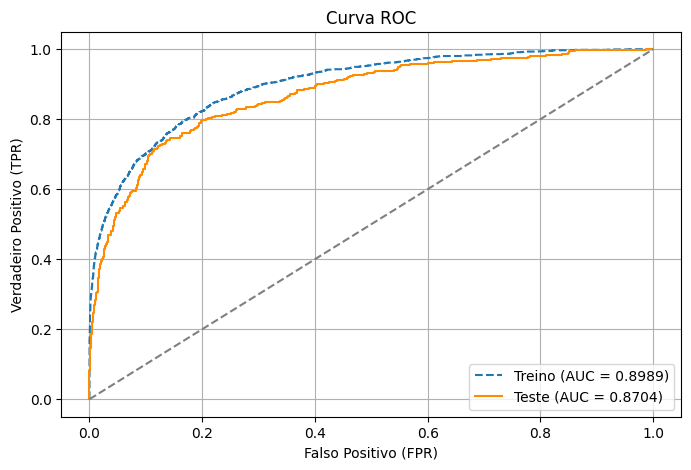

------------------------
Início: 2025-02-09 00:20:26.092238
Fim:    2025-02-09 00:48:00.044247
------------------------


In [20]:


# Verifica se há GPU disponível
use_gpu = torch.cuda.is_available()
device = "cuda" if use_gpu else "cpu"
print(f"Usando GPU: {use_gpu}")

# Número de trials para a otimização
n_trials = 100 #mudar para 300 e 100 e ver qual melhor
n_splits = 5 # folds de StratifiedKFold

# Criando uma barra de progresso
progress_bar = tqdm(total=n_trials, desc="Otimização em andamento", unit="trial")


#sampler = optuna.samplers.TPESampler(n_startup_trials=5, n_ei_candidates=10, seed=42) #versao para testes iniciais 
sampler = optuna.samplers.TPESampler(n_startup_trials=30, n_ei_candidates=100, seed=42) #versao para trials testar depis: n_startup_trials=30 , n_ei_candidates=150/200

# Função para aplicar oversampling
def apply_oversampling(X, y, method, k_neighbors, sampling_strategy):
    if method == "SMOTE":
        sampler = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=42)
    else:
        sampler = ADASYN(sampling_strategy=sampling_strategy, n_neighbors=k_neighbors, random_state=42)
    return sampler.fit_resample(X, y)

# Função para treinar o modelo XGBoost
def train_xgb(param, X_train, y_train, X_valid, y_valid):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    
    model = xgb.train(param, dtrain, num_boost_round=param['n_estimators'],
                      evals=[(dvalid, "eval")],
                      early_stopping_rounds=param['early_stopping_rounds'], 
                      verbose_eval=False)
    
    return model.predict(dvalid)



# Definição da função de otimização para o Optuna
def objective(trial):
    global progress_bar

    #há GPU disponível ? 
    use_gpu = torch.cuda.is_available() #tive que chavar com o torch pq a versao do xgboost usada nao tem get_gpu_count() vai entender ...

    # Definir as opções para 'tree_method' dependendo da disponibilidade da GPU
    tree_method_options = ['gpu_hist'] if use_gpu else ['hist', 'approx']   #Método para construir as árvores: 
                                                                             #auto: Método automaticamente escolhido com base no sistema. (ele escolhe com base em memoria, procesamento, etc.. )
                                                                             #approx: Aproximação para divisão.
                                                                             #hist: Método baseado em histogramas, eficiente para grandes datasets.
                                                                             #gpu_hist: Variante para execução em GPU.


    param = {

        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'objective': trial.suggest_categorical('objective', ['binary:logistic']), 
        #'binary:logitraw' ---> essa opcao ficou de fora mas e interessante se o resultado do modelo (logits brutos sem normalizar entre 0 e 1) for ser passado para outro modelo ex: xgboost -> logisticRegression -> predicao final
        'eval_metric': trial.suggest_categorical('eval_metric', ['logloss', 'auc']),
        
        # Hiperparâmetros para controle de complexidade
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2), #Taxa de aprendizado, Um valor baixo pode melhorar a generalização (evitar overfitting), mas requer mais iterações (maior n_estimators).
        'n_estimators': trial.suggest_int('n_estimators', 50, 100), #Número de estimadores (árvores) a serem treinados. aumentar pode melhorar ate certo ponto... 
        'max_depth': trial.suggest_int('max_depth', 3, 8), #Profundidade máxima das árvores de decisão. quanto mais fundo, maior pode ser o aprendizado de complexidades, porem podem produzir overfiting tbm 
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6), #Peso mínimo da soma das instâncias em uma folha de árvore. Valores mais altos fazem com que o modelo seja mais conservador, prevenindo o overfitting.
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0), #Fração de amostras utilizadas para treinar cada árvore. Valores menores podem reduzir overfitting, mas valores muito baixos podem impedir que o modelo aprenda bem.
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.6, 1.0), #os tres : Frações de colunas (features) usadas para construir cada árvore, nível ou nó, respectivamente.  Reduzir esses valores pode ajudar a prevenir overfitting, mas pode prejudicar a performance se for muito baixo.
        'colsample_bynode': trial.suggest_uniform('colsample_bynode', 0.6, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0.0, 0.2), #Parâmetro de regularização que controla a complexidade das árvores. Maior valor de gamma aumenta a regularização, evitando que a árvore se torne muito complexa.
        'lambda': trial.suggest_loguniform('lambda', 0.1, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 0.1, 1.0),# os dois: Parâmetros de regularização L2 (lambda) e L1 (alpha).  Ambos controlam a penalização do modelo para prevenir overfitting. A regularização L1 (alpha) pode ajudar na seleção de features, enquanto a L2 (lambda) é mais para suavizar os coeficientes.
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 100), #Peso para balancear classes em problemas desbalanceados. Aumenta o peso das classes minoritárias, ajudando a melhorar a performance para classes desbalanceadas.1
        
        'max_delta_step': trial.suggest_uniform('max_delta_step', 0.0, 0.2),#Ajuste para estabilizar o treinamento, especialmente em problemas desbalanceados. Melhora a convergência e pode ser útil em modelos com dados muito desbalanceados ou com outliers.
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),#Número de iterações sem melhoria para interromper o treinamento. Evita o overfitting, interrompendo o treinamento quando não há mais melhorias significativas na performance.
        'tree_method': trial.suggest_categorical('tree_method', tree_method_options), 
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),#Estratégia para crescer as árvores.
                                                                                            #depthwise: Expande as árvores nível por nível.
                                                                                            #lossguide: Expande as árvores com base no menor aumento de erro.
        'max_bin': trial.suggest_int('max_bin', 256, 1024), #Número máximo de bins a serem utilizados para construir histogramas.Aumentar o número de bins melhora a precisão, mas aumenta o custo computacional.
        'silent': 1,#desabilita logs.
        'monotone_constraints': trial.suggest_categorical('monotone_constraints', [None]), 
        'interaction_constraints': trial.suggest_categorical('interaction_constraints', [None]), #os dois: Restrições de monotonicidade e de interação entre features. Controla como as features interagem dentro do modelo, forçando uma relação crescente ou decrescente entre elas (monotonicidade).
        #'gpu_id': trial.suggest_int('gpu_id', 0, 0), #util quando tema mais de uma GPU pra usar(nao pode ser a NVIDIA e outra da maquina nativa por exemplo, tem qu ser tipo cloud mesmo), eu nao tenho 

    }

    
     # Inicialização do Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_idx, valid_idx in skf.split(X, y):
        # Divisão do dataset em treino e validação
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        # Aplicação de oversampling por SMOTE (apenas treino) 
        X_train, y_train = apply_oversampling(X_train, y_train, method="SMOTE", k_neighbors=5, sampling_strategy=0.7)
        
        # Treinamento do modelo e obtenção das previsões
        y_pred = train_xgb(param, X_train, y_train, X_valid, y_valid)
        
        # Cálculo do AUC-ROC e armazenamento
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)
    
    # Retorno da média dos scores AUC-ROC para otimização do Optuna
    progress_bar.update(1)
    return np.mean(auc_scores)





study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=n_trials)

best_params = study.best_params



# Melhores hiperparâmetros
print("📊 MELHORES HIPERPARÂMETROS ENCONTRADOS")
print("═" * 60)
print(f"{'Hiperparâmetro':<25}{'Valor':<15}")
print("─" * 60)
for param, value in best_params.items():
    value = value if value is not None else "N/A"  # Substituir None por "N/A"
    print(f"{param:<25}{value:<15}")
print("═" * 60)

print("✅ Otimização concluída!")
progress_bar.close()

dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)
evals_result = {}
best_params["eval_metric"] = "logloss" 
xgb_model = xgb.train(
    best_params, dtrain,
    num_boost_round=best_params['n_estimators'],  
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=best_params['early_stopping_rounds'], 
    evals_result=evals_result, 
    verbose_eval=False
)

# Predições
y_train_pred_proba = xgb_model.predict(dtrain)
y_test_pred_proba = xgb_model.predict(dtest)
y_train_pred = (y_train_pred_proba > 0.5).astype(int)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

metrics = {
    "Acurácia": accuracy_score,
    "Precisão": precision_score,
    "Recall": recall_score,
    "F1-Score": f1_score,
    "AUC-ROC": roc_auc_score,
    "MCC": matthews_corrcoef,
    "Kappa de Cohen": cohen_kappa_score,
    "Acurácia Balanceada": balanced_accuracy_score
}

print("\n📊 MÉTRICAS DO MODELO")
print("=" * 60)
print(f"{'Métrica':<20}{'Treino':<15}{'Teste':<15}")
print("-" * 60)
for metric_name, metric_func in metrics.items():
    train_score = metric_func(y_train_resampled, y_train_pred_proba if metric_name == "AUC-ROC" else y_train_pred)
    test_score = metric_func(y_test, y_test_pred_proba if metric_name == "AUC-ROC" else y_test_pred)
    print(f"{metric_name:<20}{train_score:<15.4f}{test_score:<15.4f}")
print("=" * 60)

# Curva de perda
plt.figure(figsize=(8, 5))
plt.plot(evals_result["train"]["logloss"], label="Treinamento", linestyle="--")
plt.plot(evals_result["eval"]["logloss"], label="Validação", linestyle="-")
plt.xlabel("Épocas")
plt.ylabel("Log Loss")
plt.title("Curva de Perda (Log Loss)")
plt.legend()
plt.grid()
plt.show()

# Curva ROC
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
auc_train = roc_auc_score(y_train_resampled, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr_train, tpr_train, label=f"Treino (AUC = {auc_train:.4f})", linestyle="--")
plt.plot(fpr_test, tpr_test, label=f"Teste (AUC = {auc_test:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()


# Fim
end_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print("Fim:   ", end_time_utc)
print('------------------------')
